{'CustomOptimizer4': {'iters': 155, 'lr': 0.1, 'hist': array([2.36912602e+01, 1.94848806e+01, 1.61683855e+01, 1.34963053e+01,
       1.12897751e+01, 9.42279174e+00, 7.80972408e+00, 6.40692889e+00,
       5.19695311e+00, 4.16964945e+00, 3.30870027e+00, 2.59017087e+00,
       1.99185886e+00, 1.50242720e+00, 1.12079552e+00, 8.47590062e-01,
       6.76065258e-01, 5.88197289e-01, 5.57689022e-01, 5.57276390e-01,
       5.65501236e-01, 5.69731523e-01, 5.65552919e-01, 5.54237960e-01,
       5.39452028e-01, 5.24285803e-01, 5.09748111e-01, 4.94967463e-01,
       4.78417514e-01, 4.59156917e-01, 4.37304526e-01, 4.13613690e-01,
       3.88720255e-01, 3.62803089e-01, 3.35872966e-01, 3.08274169e-01,
       2.80859617e-01, 2.54679560e-01, 2.30423655e-01, 2.07981174e-01,
       1.86415574e-01, 1.64455953e-01, 1.41285793e-01, 1.17148196e-01,
       9.33492361e-02, 7.16454360e-02, 5.34390633e-02, 3.92998269e-02,
       2.90228738e-02, 2.20310151e-02, 1.77688106e-02, 1.58597479e-02,
       1.60152112e-02,

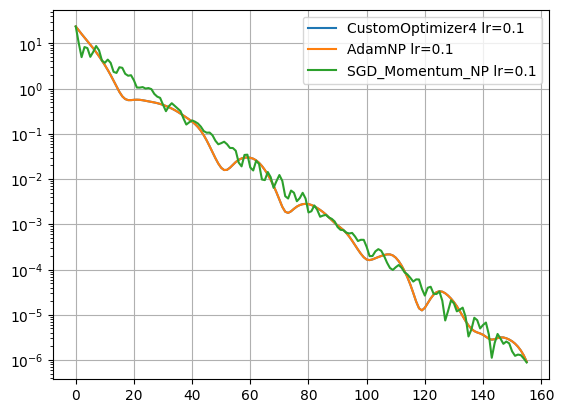

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from math import isfinite
np.random.seed(0)

class CustomOptimizer4:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, model=None):
        self.learning_rate=learning_rate
        self.beta1=beta1
        self.beta2=beta2
        self.epsilon=epsilon
        self.m=None
        self.v=None
        self.t=0
        self.prev_diff=None
        self.model=model
    def step(self,x,grad):
        if self.m is None:
            self.m=np.zeros_like(x)
            self.v=np.zeros_like(x)
            self.prev_diff=np.full_like(x,np.inf)
        self.t+=1
        self.m=self.beta1*self.m+(1-self.beta1)*grad
        self.v=self.beta2*self.v+(1-self.beta2)*(grad**2)
        m_hat=self.m/(1-self.beta1**self.t)
        v_hat=self.v/(1-self.beta2**self.t)
        x=x-self.learning_rate*m_hat/(np.sqrt(v_hat)+self.epsilon)
        return x

class AdamNP:
    def __init__(self,lr=0.001,b1=0.9,b2=0.999,eps=1e-8):
        self.lr=lr;self.b1=b1;self.b2=b2;self.eps=eps
        self.m=None;self.v=None;self.t=0
    def step(self,x,grad):
        if self.m is None:
            self.m=np.zeros_like(x);self.v=np.zeros_like(x)
        self.t+=1
        self.m=self.b1*self.m+(1-self.b1)*grad
        self.v=self.b2*self.v+(1-self.b2)*(grad**2)
        m_hat=self.m/(1-self.b1**self.t)
        v_hat=self.v/(1-self.b2**self.t)
        return x-self.lr*m_hat/(np.sqrt(v_hat)+self.eps)

class SGD_Momentum_NP:
    def __init__(self,lr=0.01,momentum=0.9):
        self.lr=lr;self.m=momentum;self.v=None
    def step(self,x,grad):
        if self.v is None:
            self.v=np.zeros_like(x)
        self.v=self.m*self.v-self.lr*grad
        return x+self.v

class RMSpropNP:
    def __init__(self,lr=0.001,rho=0.9,eps=1e-8):
        self.lr=lr;self.rho=rho;self.eps=eps;self.s=None
    def step(self,x,grad):
        if self.s is None:
            self.s=np.zeros_like(x)
        self.s=self.rho*self.s+(1-self.rho)*(grad**2)
        return x-self.lr*grad/(np.sqrt(self.s)+self.eps)

def make_Q(d,cond):
    eigs=np.logspace(0,np.log10(cond),d)
    Q=np.diag(eigs)
    U,_=np.linalg.qr(np.random.randn(d,d))
    return U@Q@U.T

def run_quad(Q,opt_class,x0,lr,tol=1e-6,maxit=20000):
    x=x0.copy()
    if opt_class is CustomOptimizer4: opt=CustomOptimizer4(lr)
    elif opt_class is AdamNP: opt=AdamNP(lr)
    elif opt_class is SGD_Momentum_NP: opt=SGD_Momentum_NP(lr)
    else: opt=RMSpropNP(lr)
    fx=0.5*x.dot(Q.dot(x))
    h=[fx]
    for i in range(maxit):
        g=Q.dot(x)
        x=opt.step(x,g)
        fx=0.5*x.dot(Q.dot(x))
        h.append(fx)
        if fx<tol and isfinite(fx): return i+1,np.array(h)
    return None,np.array(h)

d=20
Q=make_Q(d,8)
x0=np.random.randn(d)
opts=[(CustomOptimizer4,[1e-3,1e-2,1e-1]),(AdamNP,[1e-3,1e-2,1e-1]),(SGD_Momentum_NP,[1e-3,1e-2,1e-1]),(RMSpropNP,[1e-3,1e-2,1e-1])]
res={}
for o,lrs in opts:
    best={"iters":None,"lr":None,"hist":None}
    for lr in lrs:
        it,h=run_quad(Q,o,x0,lr)
        if it is not None and (best["iters"] is None or it<best["iters"]):
            best={"iters":it,"lr":lr,"hist":h}
    res[o.__name__]=best

print(res)
plt.figure()
for k,v in res.items():
    if v["hist"] is not None:
        plt.semilogy(v["hist"],label=k+" lr="+str(v["lr"]))
plt.legend();plt.grid();plt.show()


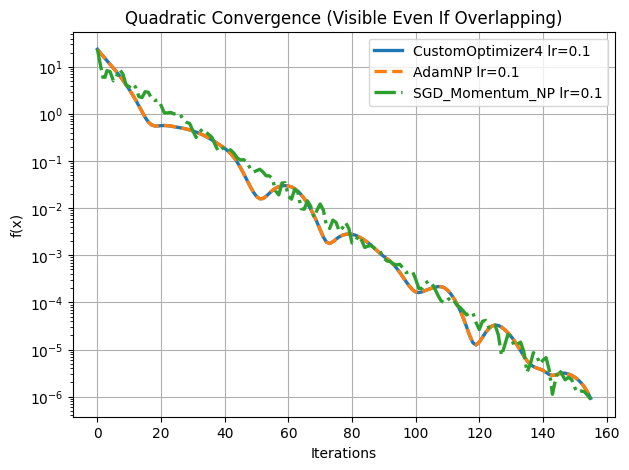

In [22]:
styles = ["solid", "dashed", "dashdot", "dotted"]
i = 0

plt.figure(figsize=(7,5))

for k,v in res.items():
    if v["hist"] is not None:
        plt.semilogy(
            v["hist"],
            label=f"{k} lr={v['lr']}",
            linestyle=styles[i % len(styles)],
            linewidth=2.4
        )
        i += 1

plt.xlabel("Iterations")
plt.ylabel("f(x)")
plt.title("Quadratic Convergence (Visible Even If Overlapping)")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\3159574861.py:79: RuntimeWarning: overflow encountered in dot
  fx=0.5*x.dot(Q.dot(x))
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\3159574861.py:77: RuntimeWarning: overflow encountered in dot
  g=Q.dot(x)
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\3159574861.py:79: RuntimeWarning: invalid value encountered in dot
  fx=0.5*x.dot(Q.dot(x))
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\3159574861.py:50: RuntimeWarning: invalid value encountered in subtract
  self.v=self.m*self.v-self.lr*grad
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\3159574861.py:77: RuntimeWarning: invalid value encountered in dot
  g=Q.dot(x)


{'CustomOptimizer4': {'iters': 4860, 'lr': 0.01, 'hist': array([1.32348956e+03, 1.28939915e+03, 1.25587986e+03, ...,
       1.01099816e-06, 1.00297480e-06, 9.95011372e-07], shape=(4861,))}, 'AdamNP': {'iters': 4860, 'lr': 0.01, 'hist': array([1.32348956e+03, 1.28939915e+03, 1.25587986e+03, ...,
       1.01099816e-06, 1.00297480e-06, 9.95011372e-07], shape=(4861,))}, 'SGD_Momentum_NP': {'iters': 637, 'lr': 0.001, 'hist': array([1.32348956e+03, 5.96190002e+02, 2.46008325e+02, 5.22272599e+02,
       6.76765294e+02, 4.07860782e+02, 2.23047336e+02, 3.89746563e+02,
       5.14102926e+02, 3.21690996e+02, 1.05540391e+02, 1.54013395e+02,
       2.89881584e+02, 2.51643806e+02, 1.24543568e+02, 1.12179647e+02,
       1.70283879e+02, 1.40577809e+02, 5.52955876e+01, 5.67819362e+01,
       1.31064066e+02, 1.42192070e+02, 6.99027070e+01, 2.50688177e+01,
       5.23934604e+01, 7.67846057e+01, 5.11575651e+01, 2.56846321e+01,
       4.21508151e+01, 6.26724588e+01, 4.52908023e+01, 1.51443658e+01,
       1

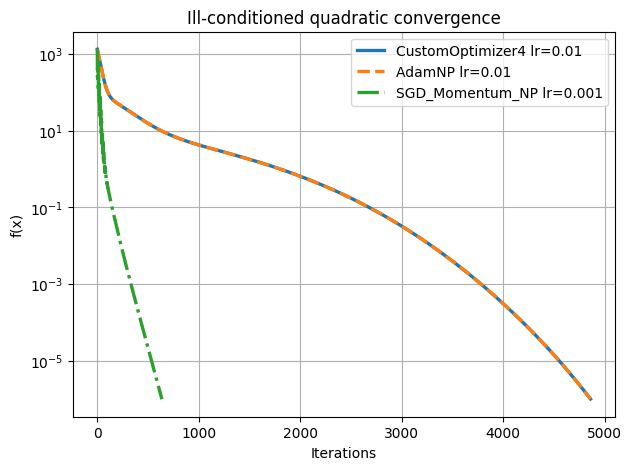

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from math import isfinite
np.random.seed(1)

d=20
Q=make_Q(d,500)
x0=np.random.randn(d)
opts=[(CustomOptimizer4,[1e-4,1e-3,1e-2]),(AdamNP,[1e-4,1e-3,1e-2]),(SGD_Momentum_NP,[1e-4,1e-3,1e-2]),(RMSpropNP,[1e-4,1e-3,1e-2])]
res={}
for o,lrs in opts:
    best={"iters":None,"lr":None,"hist":None}
    for lr in lrs:
        it,h=run_quad(Q,o,x0,lr,1e-6,50000)
        if it is not None and (best["iters"] is None or it<best["iters"]):
            best={"iters":it,"lr":lr,"hist":h}
    res[o.__name__]=best

print(res)

styles = ["solid", "dashed", "dashdot", "dotted"]
i = 0
plt.figure(figsize=(7,5))
for k,v in res.items():
    if v["hist"] is not None:
        plt.semilogy(v["hist"], label=f"{k} lr={v['lr']}", linestyle=styles[i % len(styles)], linewidth=2.4)
        i += 1
plt.xlabel("Iterations")
plt.ylabel("f(x)")
plt.title("Ill-conditioned quadratic convergence")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\2845211990.py:5: RuntimeWarning: overflow encountered in scalar power
  return (1-x[0])**2+100*(x[1]-x[0]**2)**2
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\2845211990.py:8: RuntimeWarning: overflow encountered in scalar power
  return np.array([ -2*(1-x[0]) -400*x[0]*(x[1]-x[0]**2), 200*(x[1]-x[0]**2) ])
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\2845211990.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  return (1-x[0])**2+100*(x[1]-x[0]**2)**2
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_14924\2845211990.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([ -2*(1-x[0]) -400*x[0]*(x[1]-x[0]**2), 200*(x[1]-x[0]**2) ])


{'CustomOptimizer4': {'iters': 873, 'lr': 0.1, 'hist': array([2.42000000e+01, 5.62000000e+00, 6.26692587e+00, 1.18035408e+01,
       1.28691384e+01, 9.96745582e+00, 6.26761316e+00, 4.27813295e+00,
       4.81929320e+00, 6.72357657e+00, 7.95125125e+00, 7.52112451e+00,
       6.00949914e+00, 4.60214539e+00, 4.10738582e+00, 4.54736668e+00,
       5.34151998e+00, 5.82513841e+00, 5.68750543e+00, 5.07194380e+00,
       4.39060021e+00, 4.03491942e+00, 4.13804584e+00, 4.51151307e+00,
       4.80716426e+00, 4.78916687e+00, 4.48921817e+00, 4.13489730e+00,
       3.95022141e+00, 4.00057364e+00, 4.17921098e+00, 4.31399453e+00,
       4.29670803e+00, 4.14395790e+00, 3.96414651e+00, 3.86883437e+00,
       3.89378492e+00, 3.98262876e+00, 4.04080574e+00, 4.01288185e+00,
       3.91898189e+00, 3.82645535e+00, 3.78988838e+00, 3.81199304e+00,
       3.85124557e+00, 3.86132510e+00, 3.82674148e+00, 3.76904297e+00,
       3.72422581e+00, 3.71269918e+00, 3.72566094e+00, 3.73650319e+00,
       3.72497891e+00,

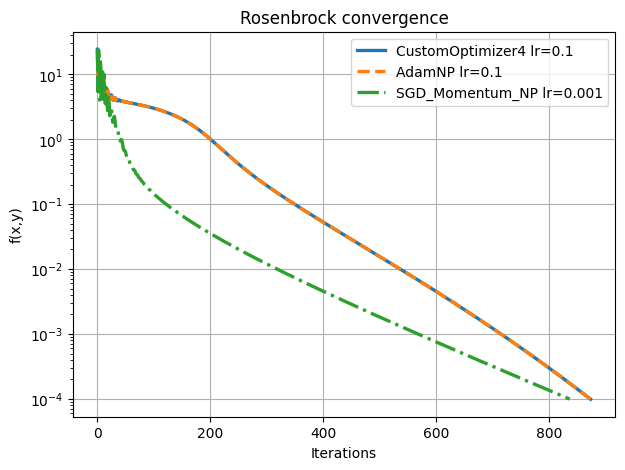

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return (1-x[0])**2+100*(x[1]-x[0]**2)**2

def g(x):
    return np.array([ -2*(1-x[0]) -400*x[0]*(x[1]-x[0]**2), 200*(x[1]-x[0]**2) ])

def run_rosen(opt_class,lr,x0,tol=1e-4,maxit=200000):
    x=x0.copy()
    if opt_class is CustomOptimizer4: opt=CustomOptimizer4(lr)
    elif opt_class is AdamNP: opt=AdamNP(lr)
    elif opt_class is SGD_Momentum_NP: opt=SGD_Momentum_NP(lr)
    else: opt=RMSpropNP(lr)
    h=[f(x)]
    for i in range(maxit):
        x=opt.step(x,g(x))
        fx=f(x)
        h.append(fx)
        if fx<tol: return i+1,np.array(h)
    return None,np.array(h)

x0=np.array([-1.2,1])
opts=[(CustomOptimizer4,[1e-3,1e-2,1e-1]),(AdamNP,[1e-3,1e-2,1e-1]),(SGD_Momentum_NP,[1e-3,1e-2,1e-1]),(RMSpropNP,[1e-3,1e-2,1e-1])]
res={}
for o,lrs in opts:
    best={"iters":None,"lr":None,"hist":None}
    for lr in lrs:
        it,h=run_rosen(o,lr,x0)
        if it is not None and (best["iters"] is None or it<best["iters"]):
            best={"iters":it,"lr":lr,"hist":h}
    res[o.__name__]=best

print(res)

styles = ["solid", "dashed", "dashdot", "dotted"]
i = 0
plt.figure(figsize=(7,5))
for k,v in res.items():
    if v["hist"] is not None:
        plt.semilogy(v["hist"], label=f"{k} lr={v['lr']}", linestyle=styles[i % len(styles)], linewidth=2.4)
        i += 1
plt.xlabel("Iterations")
plt.ylabel("f(x,y)")
plt.title("Rosenbrock convergence")
plt.grid(True)
plt.legend()
plt.show()
